# 머신러닝 모델 여정 실습 2. Airplane Delay Regression

### 데이터 분석 목적
    - 항공기가 얼마나 지연되어 도착할 지를 예측한다.
    - 지연(연착)되는 이유를 파악하고 문제점을 해결하거나 대응하여 서비스 품질을 향상시키고자 한다.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# library for feature engineering and EDA
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
from IPython.display import Image
from datetime import datetime

# library for statistic
from scipy import stats
from scipy.stats import kruskal
from scipy.stats import f_oneway

# library for machine learning
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

from xgboost import XGBRegressor

%matplotlib inline

## 1. Data Processing 1

### 1-1 Data Load

In [3]:
!pwd
path_lecture = "./drive/MyDrive/MLOps_Signature/Lecture_Practice/CH02/clip21_airplane_delay_regression/"
random_state = 1234

/content


In [4]:
# linux 계열은 \를 사용. window 계열은 /를 사용
# linux : C:\Users\Desktop\example\weather.csv
# window : C:/Users/Desktop/example/weather.csv

df_airlines = pd.read_csv(path_lecture+"data/airlines.csv")
df_flights = pd.read_csv(path_lecture+"data/flights.csv")
df_tzone_meta = pd.read_csv(path_lecture+"data/tzone_meta.csv")
df_airports = pd.read_csv(path_lecture+"data/airports.csv")
df_planes = pd.read_csv(path_lecture+"data/planes.csv")
df_weather = pd.read_csv(path_lecture+"data/weather.csv")

##### 데이터 확인 : 데이터를 간략히 파악하고 어떻게 join하여 사용할 지에 대해서 고민

In [5]:
# 데이터의 필요성 확인, 항공사 정보
df_airlines.head(3)

,carrier,name
0,AA,American Airlines Inc.
1,AS,Alaska Airlines Inc.
2,B6,JetBlue Airways


In [137]:
# 운행 이력 정보
df_flights.head(3)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,flight,tailnum,origin,dest,air_time,distance,hour,minute,time_hour
0,2017,10,1,27.0,2114,193.0,317.0,15,182.0,UA,1537,N54711,EWR,MIA,148.0,1085.0,21.0,14.0,2017-10-01 21:00:00
1,2017,10,1,519.0,525,-6.0,741.0,759,-18.0,UA,1161,N37287,EWR,IAH,183.0,1400.0,5.0,25.0,2017-10-01 05:00:00
2,2017,10,1,544.0,545,-1.0,815.0,819,-4.0,B6,27,N547JB,EWR,MCO,133.0,937.0,5.0,45.0,2017-10-01 05:00:00


In [6]:
#  운행 이력의 결측치 확인
# 1. 데이터를 분석하는 것에 큰 영향을 끼치는지
# 2. 문제 해결에 영향을 끼친다면, 어떻게 처리할 것인지 (결측치를 채우거나 제거)
df_flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303748 entries, 0 to 303747
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year            303748 non-null  int64  
 1   month           303748 non-null  int64  
 2   day             303748 non-null  int64  
 3   dep_time        295938 non-null  float64
 4   sched_dep_time  303748 non-null  int64  
 5   dep_delay       295934 non-null  float64
 6   arr_time        295600 non-null  float64
 7   sched_arr_time  303748 non-null  int64  
 8   arr_delay       294896 non-null  float64
 9   carrier         303748 non-null  object 
 10  flight          303748 non-null  int64  
 11  tailnum         302757 non-null  object 
 12  origin          303748 non-null  object 
 13  dest            303748 non-null  object 
 14  air_time        294896 non-null  float64
 15  distance        303748 non-null  float64
 16  hour            303748 non-null  float64
 17  minute    

In [7]:
df_flights.isna().sum()

year                 0
month                0
day                  0
dep_time          7810
sched_dep_time       0
dep_delay         7814
arr_time          8148
sched_arr_time       0
arr_delay         8852
carrier              0
flight               0
tailnum            991
origin               0
dest                 0
air_time          8852
distance             0
hour                 0
minute               0
time_hour            0
dtype: int64

##### 결측치 처리 1

In [8]:
# arr_delay(Target Value) 결측치가 중요
df_flights.dropna(subset=["arr_delay"]).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294896 entries, 0 to 303738
Data columns (total 19 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year            294896 non-null  int64  
 1   month           294896 non-null  int64  
 2   day             294896 non-null  int64  
 3   dep_time        294896 non-null  float64
 4   sched_dep_time  294896 non-null  int64  
 5   dep_delay       294896 non-null  float64
 6   arr_time        294896 non-null  float64
 7   sched_arr_time  294896 non-null  int64  
 8   arr_delay       294896 non-null  float64
 9   carrier         294896 non-null  object 
 10  flight          294896 non-null  int64  
 11  tailnum         294896 non-null  object 
 12  origin          294896 non-null  object 
 13  dest            294896 non-null  object 
 14  air_time        294896 non-null  float64
 15  distance        294896 non-null  float64
 16  hour            294896 non-null  float64
 17  minute    

In [9]:
# arr_delay는 target data이기 때문에, 결측치인 경우에는 제거
df_flights = df_flights.dropna(subset=["arr_delay"]).copy()

In [10]:
# timezone 데이터
df_tzone_meta.head(3)
# 데이터 분석에는 크게 필요할 거 같지 않은 데이터

,tzone,tzone_name
0,1,America/New_York
1,2,America/Chicago
2,3,America/Denver


In [143]:
# 공항 정보
df_airports.head(3)

,faa,name,lat,lon,alt,tz,dst,tzone
0,0V4,Brookneal/Campbell County Airport,37.141701,-79.016403,596,-5.0,A,1.0
1,19S,Sublette Municipal Airport,37.491402,-100.830002,2908,-5.0,A,NaN
2,23M,Clarke County Airport,32.084900,-88.738899,320,-6.0,A,2.0


In [11]:
# 결측치 확인
df_airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1333 entries, 0 to 1332
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   faa     1333 non-null   object 
 1   name    1333 non-null   object 
 2   lat     1333 non-null   float64
 3   lon     1333 non-null   float64
 4   alt     1333 non-null   int64  
 5   tz      1277 non-null   float64
 6   dst     1277 non-null   object 
 7   tzone   1199 non-null   float64
dtypes: float64(4), int64(1), object(3)
memory usage: 83.4+ KB


In [12]:
# df_flights와 df_airport를 join할 수 있을지 검토
# df_flight에는 airport정보가 2개 (key) -> dest와 origin
# df_airport에는 faa 정보가 key.
df_airports.faa.unique()

array(['0V4', '19S', '23M', ..., 'ZSY', 'ZUN', 'ZZV'], dtype=object)

In [13]:
# df_flight의 dest에 기반해서 df_airport를 join할 수 있을지 검토
# https://numpy.org/doc/stable/reference/generated/numpy.intersect1d.html
np.intersect1d(df_flights.dest.unique(), df_airports.faa.unique())

array(['ABQ', 'ACK', 'ALB', 'ANC', 'ATL', 'AUS', 'AVL', 'AVP', 'BDL',
       'BGR', 'BHM', 'BNA', 'BOS', 'BTV', 'BUF', 'BUR', 'BWI', 'BZN',
       'CAE', 'CAK', 'CHA', 'CHO', 'CHS', 'CLE', 'CLT', 'CMH', 'CVG',
       'DAB', 'DAL', 'DAY', 'DCA', 'DEN', 'DFW', 'DSM', 'DTW', 'EGE',
       'FLL', 'FNT', 'FWA', 'GRR', 'GSO', 'GSP', 'HDN', 'HNL', 'HOU',
       'HYA', 'IAD', 'IAH', 'ILM', 'IND', 'JAC', 'JAX', 'LAS', 'LAX',
       'LEX', 'LGB', 'MCI', 'MCO', 'MDW', 'MEM', 'MHT', 'MIA', 'MKE',
       'MSN', 'MSP', 'MSY', 'MTJ', 'MVY', 'MYR', 'OAK', 'OMA', 'ORD',
       'ORF', 'PBI', 'PDX', 'PHL', 'PHX', 'PIT', 'PSP', 'PVD', 'PWM',
       'RDU', 'RIC', 'RNO', 'ROC', 'RSW', 'SAN', 'SAT', 'SAV', 'SBN',
       'SDF', 'SEA', 'SFO', 'SJC', 'SLC', 'SMF', 'SNA', 'SRQ', 'STL',
       'SYR', 'TPA', 'TUS', 'TVC', 'TYS', 'XNA'], dtype=object)

In [14]:
# df_flight의 origin에 기반해서 df_airport를 join할 수 있을지 검토
np.intersect1d(df_flights.origin.unique(), df_airports.faa.unique())

array(['EWR', 'JFK', 'LGA'], dtype=object)

In [15]:
# 항공기 정보 데이터
df_planes.head(3)

,tailnum,year,type,manufacturer,model,engines,seats,speed,engine
0,N102AA,2007.0,Fixed wing single engine,AVIAT AIRCRAFT INC,A-1B,1,2.0,NaN,Reciprocating
1,N103AA,2007.0,Fixed wing single engine,AVIAT AIRCRAFT INC,A-1B,1,2.0,NaN,Reciprocating
2,N103SY,2014.0,Fixed wing multi engine,EMBRAER S A,ERJ 170-200 LR,2,88.0,NaN,Turbo-fan


In [16]:
# 결측치 및 컬럼 유형 파악
df_planes.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3521 entries, 0 to 3520
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   tailnum       3521 non-null   object 
 1   year          3419 non-null   float64
 2   type          3521 non-null   object 
 3   manufacturer  3521 non-null   object 
 4   model         3521 non-null   object 
 5   engines       3521 non-null   int64  
 6   seats         3511 non-null   float64
 7   speed         62 non-null     float64
 8   engine        3521 non-null   object 
dtypes: float64(3), int64(1), object(5)
memory usage: 247.7+ KB


In [17]:
df_planes.isna().sum()

tailnum            0
year             102
type               0
manufacturer       0
model              0
engines            0
seats             10
speed           3459
engine             0
dtype: int64

In [18]:
# speed 변수는 대부분 missing value이기 때문에 제거
df_planes = df_planes.drop("speed", axis=1)

In [19]:
# 날씨 데이터
df_weather.head(3)

,origin,year,month,day,hour,temp,dewp,humid,wind_dir,wind_speed,wind_gust,precip,pressure,visib,time_hour
0,EWR,2017.0,1.0,1,0,NaN,NaN,NaN,200.0,17.26170,19.864419,NaN,NaN,10.0,2017-01-01 08:00:00
1,EWR,2017.0,1.0,1,1,NaN,NaN,NaN,220.0,16.11092,18.540125,NaN,NaN,10.0,2017-01-01 09:00:00
2,EWR,2017.0,1.0,1,2,NaN,NaN,NaN,190.0,11.50780,13.242946,NaN,NaN,10.0,2017-01-01 10:00:00


In [20]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26201 entries, 0 to 26200
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   origin      26201 non-null  object 
 1   year        26201 non-null  float64
 2   month       26201 non-null  float64
 3   day         26201 non-null  int64  
 4   hour        26201 non-null  int64  
 5   temp        559 non-null    float64
 6   dewp        559 non-null    float64
 7   humid       559 non-null    float64
 8   wind_dir    23540 non-null  float64
 9   wind_speed  23554 non-null  float64
 10  wind_gust   23554 non-null  float64
 11  precip      1370 non-null   float64
 12  pressure    433 non-null    float64
 13  visib       26190 non-null  float64
 14  time_hour   26201 non-null  object 
dtypes: float64(11), int64(2), object(2)
memory usage: 3.0+ MB


In [21]:
# temp, dewp, humid, precip, pressure 변수는 대부분 missing value 이기 때문에 제거.
df_weather = df_weather.drop(["temp", "dewp", "humid","precip","pressure"], axis=1)
df_weather

,origin,year,month,day,hour,wind_dir,wind_speed,wind_gust,visib,time_hour
0,EWR,2017.0,1.0,1,0,200.0,17.26170,19.864419,10.0,2017-01-01 08:00:00
1,EWR,2017.0,1.0,1,1,220.0,16.11092,18.540125,10.0,2017-01-01 09:00:00
2,EWR,2017.0,1.0,1,2,190.0,11.50780,13.242946,10.0,2017-01-01 10:00:00
3,EWR,2017.0,1.0,1,3,190.0,8.05546,9.270062,10.0,2017-01-01 11:00:00
4,EWR,2017.0,1.0,1,4,220.0,9.20624,10.594357,10.0,2017-01-01 12:00:00
...,...,...,...,...,...,...,...,...,...,...
26196,LGA,2017.0,12.0,30,19,210.0,9.20624,10.594357,5.0,2017-12-31 03:00:00
26197,LGA,2017.0,12.0,30,20,200.0,10.35702,11.918651,10.0,2017-12-31 04:00:00
26198,LGA,2017.0,12.0,30,21,280.0,8.05546,9.270062,10.0,2017-12-31 05:00:00
26199,LGA,2017.0,12.0,30,22,260.0,10.35702,11.918651,10.0,2017-12-31 06:00:00


In [22]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26201 entries, 0 to 26200
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   origin      26201 non-null  object 
 1   year        26201 non-null  float64
 2   month       26201 non-null  float64
 3   day         26201 non-null  int64  
 4   hour        26201 non-null  int64  
 5   wind_dir    23540 non-null  float64
 6   wind_speed  23554 non-null  float64
 7   wind_gust   23554 non-null  float64
 8   visib       26190 non-null  float64
 9   time_hour   26201 non-null  object 
dtypes: float64(6), int64(2), object(2)
memory usage: 2.0+ MB


##### 결측치 처리 2
*   날씨는 바로 직전, 직후 날씨와 유사성을 보일 것이기 때문에 이를 활용하여 채워 넣는다.



In [23]:
df_weather.sort_values(["origin", "time_hour"]).groupby("origin").apply(lambda x : x.fillna(method="ffill")) \
                                                    .groupby("origin").apply(lambda x : x.fillna(method="bfill")).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 26201 entries, 0 to 26200
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   origin      26201 non-null  object 
 1   year        26201 non-null  float64
 2   month       26201 non-null  float64
 3   day         26201 non-null  int64  
 4   hour        26201 non-null  int64  
 5   wind_dir    26201 non-null  float64
 6   wind_speed  26201 non-null  float64
 7   wind_gust   26201 non-null  float64
 8   visib       26201 non-null  float64
 9   time_hour   26201 non-null  object 
dtypes: float64(6), int64(2), object(2)
memory usage: 2.2+ MB


<ipython-input-23-c76fec465a12>:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_weather.sort_values(["origin", "time_hour"]).groupby("origin").apply(lambda x : x.fillna(method="ffill")) \
<ipython-input-23-c76fec465a12>:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .groupby("origin").appl

In [24]:
df_weather = df_weather.sort_values(["origin", "time_hour"]).groupby("origin").apply(lambda x : x.fillna(method="ffill")) \
                                                    .groupby("origin").apply(lambda x : x.fillna(method="bfill"))

<ipython-input-24-cdc015285c12>:1: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  df_weather = df_weather.sort_values(["origin", "time_hour"]).groupby("origin").apply(lambda x : x.fillna(method="ffill")) \
<ipython-input-24-cdc015285c12>:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  .groupby("

In [25]:
df_weather.isna().sum()

origin        0
year          0
month         0
day           0
hour          0
wind_dir      0
wind_speed    0
wind_gust     0
visib         0
time_hour     0
dtype: int64

### 1-3 Data Join
##### join 진행
##### 1. df_flights는 df_airports 와 join : df_flights["dest"], df_airports["faa"]  혹은  df_flights["origin"], df_flights["faa"] 가능하나,  origin은 공항수가 적기때문에 dest에 대해서만 join을 진행
        flight 정보에 airports(공항) 세부 정보를 결합
##### 2. 1번 결과와 df_planes join : 1번_df["tailnum"], df_planes["tailnum"]
        flight 정보에 planes(항공기) 세부 정보를 결합
##### 3. 2번 결과와 df_weather : 2번_df[["origin", "time_hour"]], df_weather[["origin", "time_hour"]]
        flight 정보에 출발한 지역의 날씨와 도착한 지역의 날씨 정보를 결합

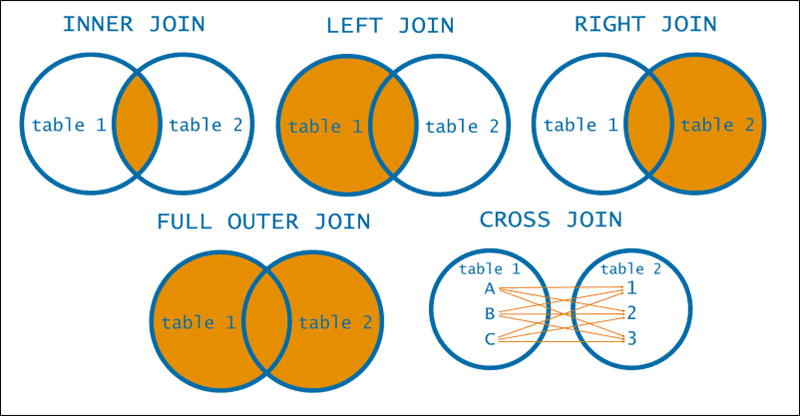

In [195]:
Image(path_lecture+"img/jointypes.png")

In [26]:
# 1. df_flights는 df_airports 와 join
# origin에 대해서는 join하지 않음 -> 개인의 판단에 따라 진행할 수도 있음
df_flight_and_airport = pd.merge(df_flights, df_airports, how='left', left_on='dest', right_on='faa')
df_flight_and_airport.head(2)

,year,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,minute,time_hour,faa,name,lat,lon,alt,tz,dst,tzone
0,2017,10,1,27.0,2114,193.0,317.0,15,182.0,UA,...,14.0,2017-10-01 21:00:00,MIA,Miami International Airport,25.7932,-80.290604,8.0,-5.0,A,1.0
1,2017,10,1,519.0,525,-6.0,741.0,759,-18.0,UA,...,25.0,2017-10-01 05:00:00,IAH,George Bush Intercontinental Houston Airport,29.9844,-95.341400,97.0,-6.0,A,2.0


In [27]:
# 2. 1번 결과와 df_planes join
# 동일한 column name이 있으면 suffixes를 통해 이름을 다르게 join가능
df_f_a_p = pd.merge(df_flight_and_airport, df_planes, how='left', on='tailnum', suffixes=("_flights","_planes"))
df_f_a_p.head(2)

,year_flights,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,tz,dst,tzone,year_planes,type,manufacturer,model,engines,seats,engine
0,2017,10,1,27.0,2114,193.0,317.0,15,182.0,UA,...,-5.0,A,1.0,1998.0,Fixed wing multi engine,BOEING,737-724,2.0,149.0,Turbo-fan
1,2017,10,1,519.0,525,-6.0,741.0,759,-18.0,UA,...,-6.0,A,2.0,2004.0,Fixed wing multi engine,BOEING,737-824,2.0,149.0,Turbo-fan


In [28]:
# 3. 2번 결과와 df_weather join
# 2가지 정보에 대한 join이 가능
# 1) 출발 시간의 날씨 정보
# 2) 도착 시간의 날씨 정보 : 주어진 자료로 구하기 모호해서 진행하지 않음. 만약 가능하다면 진행하는 것도 좋음.

# 3-1) 출발 시간의 날씨 정보
df_f_a_p["dest_datetime"] = pd.to_datetime(df_f_a_p["time_hour"])
# time_hour는 출발 예정 시간을 반영하기 떄문에, 이 데이터에 실제 delayed departure 시간을 더해줘야 한다.
# 또한, time_hour는 '분'시간이 제외된 데이터이기 때문에, minutes 컬럼 데이터도 더해줘야 한다.
df_f_a_p["dest_datetime"] = df_f_a_p.apply(lambda x : x.dest_datetime + pd.Timedelta(minutes=x.dep_delay) + pd.Timedelta(minutes=x.minute), axis=1)

In [29]:
df_f_a_p["time_hour"]

0         2017-10-01 21:00:00
1         2017-10-01 05:00:00
2         2017-10-01 05:00:00
3         2017-10-01 05:00:00
4         2017-10-01 06:00:00
                 ...         
294891    2017-09-30 22:00:00
294892    2017-09-30 22:00:00
294893    2017-09-30 22:00:00
294894    2017-09-30 23:00:00
294895    2017-09-30 22:00:00
Name: time_hour, Length: 294896, dtype: object

In [30]:
df_f_a_p["dest_datetime"]

0        2017-10-02 00:27:00
1        2017-10-01 05:19:00
2        2017-10-01 05:44:00
3        2017-10-01 05:46:00
4        2017-10-01 05:52:00
                 ...        
294891   2017-09-30 22:38:00
294892   2017-09-30 22:41:00
294893   2017-09-30 22:48:00
294894   2017-09-30 23:19:00
294895   2017-09-30 23:25:00
Name: dest_datetime, Length: 294896, dtype: datetime64[ns]

In [164]:
df_f_a_p.head(1)

,year_flights,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,dst,tzone,year_planes,type,manufacturer,model,engines,seats,engine,dest_datetime
0,2017,10,1,27.0,2114,193.0,317.0,15,182.0,UA,...,A,1.0,1998.0,Fixed wing multi engine,BOEING,737-724,2.0,149.0,Turbo-fan,2017-10-02 00:27:00


In [165]:
df_weather.head(2)

,origin,year,month,day,hour,wind_dir,wind_speed,wind_gust,visib,time_hour
0,EWR,2017.0,1.0,1,0,200.0,17.26170,19.864419,10.0,2017-01-01 08:00:00
1,EWR,2017.0,1.0,1,1,220.0,16.11092,18.540125,10.0,2017-01-01 09:00:00


In [31]:
# weather와 join 할 수 있게 dest_datetime 데이터에서 분 정보를 제거
df_f_a_p["dest_datetime"] = df_f_a_p["dest_datetime"].dt.strftime("%Y-%m-%d %H:00:00")
df_f_a_p.head(1)

,year_flights,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,dst,tzone,year_planes,type,manufacturer,model,engines,seats,engine,dest_datetime
0,2017,10,1,27.0,2114,193.0,317.0,15,182.0,UA,...,A,1.0,1998.0,Fixed wing multi engine,BOEING,737-724,2.0,149.0,Turbo-fan,2017-10-02 00:00:00


In [32]:
df_f_a_p["dest_datetime"]

0         2017-10-02 00:00:00
1         2017-10-01 05:00:00
2         2017-10-01 05:00:00
3         2017-10-01 05:00:00
4         2017-10-01 05:00:00
                 ...         
294891    2017-09-30 22:00:00
294892    2017-09-30 22:00:00
294893    2017-09-30 22:00:00
294894    2017-09-30 23:00:00
294895    2017-09-30 23:00:00
Name: dest_datetime, Length: 294896, dtype: object

In [33]:
# join을 위해 df_weather의 time_hour를 dest_datetime으로 변경
df_weather = df_weather.rename(columns={'time_hour': 'dest_datetime' })

In [34]:
df_final = pd.merge(df_f_a_p, df_weather, how="left", on=["origin","dest_datetime"], suffixes=("", "_weather"))
# _x, _y

In [35]:
df_final.head()

,year_flights,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,engine,dest_datetime,year,month_weather,day_weather,hour_weather,wind_dir,wind_speed,wind_gust,visib
0,2017,10,1,27.0,2114,193.0,317.0,15,182.0,UA,...,Turbo-fan,2017-10-02 00:00:00,2017.0,10.0,1.0,17.0,40.0,9.20624,10.594357,10.0
1,2017,10,1,519.0,525,-6.0,741.0,759,-18.0,UA,...,Turbo-fan,2017-10-01 05:00:00,2017.0,9.0,30.0,22.0,360.0,16.11092,18.540125,10.0
2,2017,10,1,544.0,545,-1.0,815.0,819,-4.0,B6,...,Turbo-fan,2017-10-01 05:00:00,2017.0,9.0,30.0,22.0,360.0,16.11092,18.540125,10.0
3,2017,10,1,546.0,550,-4.0,702.0,719,-17.0,UA,...,Turbo-fan,2017-10-01 05:00:00,2017.0,9.0,30.0,22.0,360.0,19.56326,22.513008,10.0
4,2017,10,1,552.0,600,-8.0,846.0,850,-4.0,NK,...,Turbo-fan,2017-10-01 05:00:00,2017.0,9.0,30.0,22.0,360.0,16.11092,18.540125,10.0


### 1-4 Duplicated Data 확인

In [36]:
print("중복된 항목 수 :", len(df_final[df_final.duplicated()]))


# 1. join의 문제.
# 2. data 수집 시스템 문제.
# 3. data 학습 준비 과정에서 문제.


중복된 항목 수 : 0


## 2. Data EDA

### 2-1 Data Type and Summary

In [37]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294896 entries, 0 to 294895
Data columns (total 43 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   year_flights    294896 non-null  int64  
 1   month           294896 non-null  int64  
 2   day             294896 non-null  int64  
 3   dep_time        294896 non-null  float64
 4   sched_dep_time  294896 non-null  int64  
 5   dep_delay       294896 non-null  float64
 6   arr_time        294896 non-null  float64
 7   sched_arr_time  294896 non-null  int64  
 8   arr_delay       294896 non-null  float64
 9   carrier         294896 non-null  object 
 10  flight          294896 non-null  int64  
 11  tailnum         294896 non-null  object 
 12  origin          294896 non-null  object 
 13  dest            294896 non-null  object 
 14  air_time        294896 non-null  float64
 15  distance        294896 non-null  float64
 16  hour            294896 non-null  float64
 17  minute    

In [38]:
df_final.isna().sum()

year_flights          0
month                 0
day                   0
dep_time              0
sched_dep_time        0
dep_delay             0
arr_time              0
sched_arr_time        0
arr_delay             0
carrier               0
flight                0
tailnum               0
origin                0
dest                  0
air_time              0
distance              0
hour                  0
minute                0
time_hour             0
faa                5982
name               5982
lat                5982
lon                5982
alt                5982
tz                 5982
dst                5982
tzone              5982
year_planes       43853
type              36313
manufacturer      36313
model             36313
engines           36313
seats             36930
engine            36313
dest_datetime         0
year                783
month_weather       783
day_weather         783
hour_weather        783
wind_dir            783
wind_speed          783
wind_gust       

In [ ]:
# categorical data와 numerical data를 나누기 위해 heuristic하게 확인
# 1. data 명세서
# 2. 각 데이터 컬럼의 unique() -> unique 값들을 확인
for column_name in list(df_final.columns):
    print(column_name, type(df_final[column_name][0]), df_final[column_name].unique())

year_flights <class 'numpy.int64'> [2017]
month <class 'numpy.int64'> [10 11 12  1  2  3  4  5  6  7  8  9]
day <class 'numpy.int64'> [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
dep_time <class 'numpy.float64'> [ 27. 519. 544. ... 254. 425. 400.]
sched_dep_time <class 'numpy.int64'> [2114  525  545 ... 2231 2111 2354]
dep_delay <class 'numpy.float64'> [ 1.930e+02 -6.000e+00 -1.000e+00 -4.000e+00 -8.000e+00 -7.000e+00
 -1.200e+01 -5.000e+00 -3.000e+00 -9.000e+00  7.330e+02  0.000e+00
  3.300e+01  1.000e+00 -1.100e+01 -1.000e+01 -2.000e+00  1.200e+01
 -1.400e+01  5.000e+00  3.000e+00  2.000e+00  1.500e+01  1.400e+01
  3.400e+01  5.200e+01  1.530e+02 -1.700e+01 -1.600e+01  7.000e+00
 -1.300e+01  2.200e+01  8.000e+00  6.100e+01 -2.100e+01  7.600e+01
  2.800e+01  4.000e+00  9.000e+00  1.020e+02  1.080e+02 -1.500e+01
  1.800e+01  5.000e+01  1.900e+01  6.000e+00  4.900e+01  2.000e+01
  1.000e+01  3.000e+01  2.300e+01  5.600e+01  1.600e+01  6

In [174]:
# int type 컬럼이 categorical한 특성을 보이기도 하기때문에, 이런 경우에는 heuristic하게 판단하며 column을 구분짓는다.
df_final.select_dtypes(include=['int64']).columns

Index(['year_flights', 'month', 'day', 'sched_dep_time', 'sched_arr_time',
       'flight'],
      dtype='object')

In [175]:
# float type 컬럼이 numeric한 특성을 보이지 않는 경우, 이런 경우에도 heuristic하게 판단하여 column을 구분짓는다.
df_final.select_dtypes(include=['float64']).columns

# dep_time, arr_time은 시간을 의미하며, hour과 minute 데이터가 datetime형태 (%H%M) 이기 때문에 변환필요
# wind_dir도 categorical한 특성으로 간주 (각도이기 때문)

Index(['dep_time', 'dep_delay', 'arr_time', 'arr_delay', 'air_time',
       'distance', 'hour', 'minute', 'lat', 'lon', 'alt', 'tz', 'tzone',
       'year_planes', 'engines', 'seats', 'year', 'month_weather',
       'day_weather', 'hour_weather', 'wind_dir', 'wind_speed', 'wind_gust',
       'visib'],
      dtype='object')

In [39]:
df_final["dep_time"] = df_final["dep_time"].apply(lambda x: '{0:04d}'.format(int(x)))
df_final["arr_time"] = df_final["arr_time"].apply(lambda x: '{0:04d}'.format(int(x)))
df_final["wind_dir"] = df_final["wind_dir"].astype("str")

In [40]:
df_final.head(3)

,year_flights,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,engine,dest_datetime,year,month_weather,day_weather,hour_weather,wind_dir,wind_speed,wind_gust,visib
0,2017,10,1,0027,2114,193.0,0317,15,182.0,UA,...,Turbo-fan,2017-10-02 00:00:00,2017.0,10.0,1.0,17.0,40.0,9.20624,10.594357,10.0
1,2017,10,1,0519,525,-6.0,0741,759,-18.0,UA,...,Turbo-fan,2017-10-01 05:00:00,2017.0,9.0,30.0,22.0,360.0,16.11092,18.540125,10.0
2,2017,10,1,0544,545,-1.0,0815,819,-4.0,B6,...,Turbo-fan,2017-10-01 05:00:00,2017.0,9.0,30.0,22.0,360.0,16.11092,18.540125,10.0


In [41]:
list_categorical_columns = list(df_final.select_dtypes(include=['int64', 'object']).columns)
list_numeric_columns = list(df_final.select_dtypes(include=['float64']).columns)
target_column = "arr_delay"

In [42]:
print(len(df_final.columns))
print(len(list_categorical_columns))
print(len(list_numeric_columns))

43
22
21


##### Summary of Data Set
##### Number of Variables : 43
    numeric variables : 21 (target 포함)
    categorical variables : 22
##### Number of observations : 294896
##### Duplicated Rows : 0

### 2-2 Dependent(종속) Data Explore

<Axes: xlabel='arr_delay', ylabel='Count'>

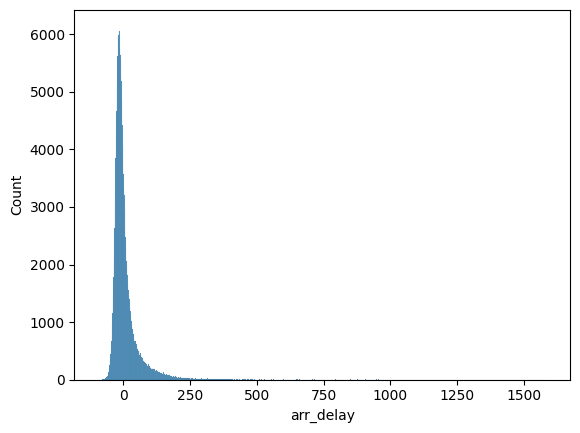

In [180]:
sns.histplot(data=df_final, x="arr_delay")

In [43]:
# https://ko.wikipedia.org/wiki/비대칭도
print(stats.skew(df_final["arr_delay"]))
# https://ko.wikipedia.org/wiki/첨도
print(stats.kurtosis(df_final["arr_delay"]))

5.559168844552731
64.17521265711945


<Axes: xlabel='arr_delay'>

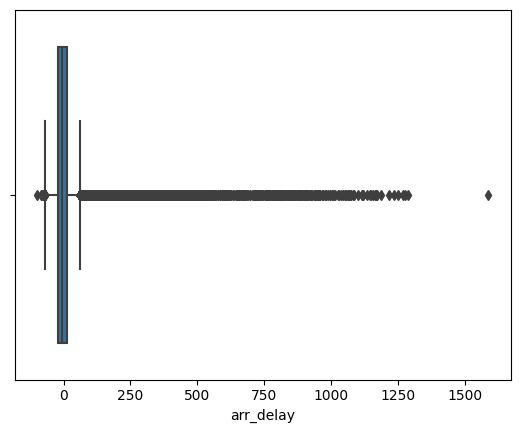

In [44]:
sns.boxplot(data=df_final, x="arr_delay")

<Axes: xlabel='arr_delay'>

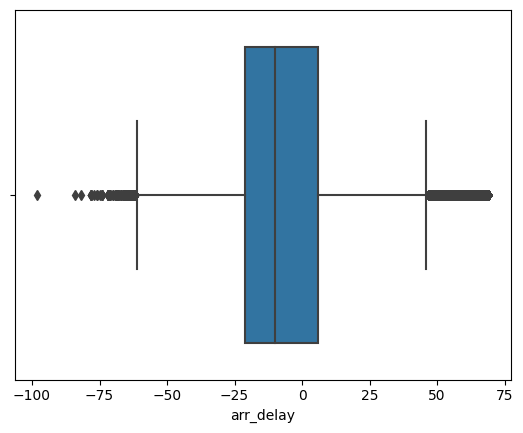

In [45]:
sns.boxplot(data=df_final[df_final.arr_delay < 70], x="arr_delay")

In [46]:
df_final["arr_delay"].describe()

count    294896.000000
mean          7.104023
std          55.323259
min         -98.000000
25%         -20.000000
50%          -7.000000
75%          13.000000
max        1589.000000
Name: arr_delay, dtype: float64

### 2-3 Independent(독립) Data Explore

In [185]:
df_final.head()

,year_flights,month,day,dep_time,sched_dep_time,dep_delay,arr_time,sched_arr_time,arr_delay,carrier,...,engine,dest_datetime,year,month_weather,day_weather,hour_weather,wind_dir,wind_speed,wind_gust,visib
0,2017,10,1,0027,2114,193.0,0317,15,182.0,UA,...,Turbo-fan,2017-10-02 00:00:00,2017.0,10.0,1.0,17.0,40.0,9.20624,10.594357,10.0
1,2017,10,1,0519,525,-6.0,0741,759,-18.0,UA,...,Turbo-fan,2017-10-01 05:00:00,2017.0,9.0,30.0,22.0,360.0,16.11092,18.540125,10.0
2,2017,10,1,0544,545,-1.0,0815,819,-4.0,B6,...,Turbo-fan,2017-10-01 05:00:00,2017.0,9.0,30.0,22.0,360.0,16.11092,18.540125,10.0
3,2017,10,1,0546,550,-4.0,0702,719,-17.0,UA,...,Turbo-fan,2017-10-01 05:00:00,2017.0,9.0,30.0,22.0,360.0,19.56326,22.513008,10.0
4,2017,10,1,0552,600,-8.0,0846,850,-4.0,NK,...,Turbo-fan,2017-10-01 05:00:00,2017.0,9.0,30.0,22.0,360.0,16.11092,18.540125,10.0


In [186]:
df_final.describe().to_csv(path_lecture + "data/describe.csv")

#### 불필요한 컬럼 제거하기
*   생각해보기!! - 혼자 고민해서 불필요한 컬럼 정해보자



In [47]:
df_final.apply(lambda x : x.unique())

year_flights                                                 [2017]
month                       [10, 11, 12, 1, 2, 3, 4, 5, 6, 7, 8, 9]
day               [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
dep_time          [0027, 0519, 0544, 0546, 0552, 0553, 0554, 055...
sched_dep_time    [2114, 525, 545, 550, 600, 607, 606, 610, 615,...
dep_delay         [193.0, -6.0, -1.0, -4.0, -8.0, -7.0, -12.0, -...
arr_time          [0317, 0741, 0815, 0702, 0846, 0852, 0844, 083...
sched_arr_time    [15, 759, 819, 719, 850, 858, 844, 853, 902, 8...
arr_delay         [182.0, -18.0, -4.0, -17.0, -6.0, 0.0, -22.0, ...
carrier            [UA, B6, NK, AA, DL, WN, EV, AS, OO, VX, F9, HA]
flight            [1537, 1161, 27, 761, 521, 23, 129, 1465, 1301...
tailnum           [N54711, N37287, N547JB, N38446, N675NK, N967J...
origin                                              [EWR, LGA, JFK]
dest              [MIA, IAH, MCO, ORD, FLL, LAX, DFW, ATL, MDW, ...
air_time          [148.0, 183.0, 133.0, 108.0, 1

##### 불필요한 컬럼 (모두가 다를 수 있음)
    year_flights : 모두 동일한 값을 갖기 때문에 제외
    sched_dep_time : 예정 시간은 유의미한 데이터가 아니므로 제거
    arr_time : arr_delay target 변수와 동일한 데이터 의미를 갖기 때문에 제거 -> data leakage가 발생할 수 있음
    sched_arr_time : 예정 시간은 유의미한 데이터가 아니므로 제거
    hour : sched_dep_time의 정보이기 때문에 제거 (출발 예정 시간은 의미가 없다고 판단, 실제 출발한 시간이 중요)
    minute : sched_dep_time의 정보이기 때문에 제거 (출발 예정 시간은 의미가 없다고 판단, 실제 출발한 시간이 중요)
    time_hour : 출발 예정 시간을 기준으로 만들어졌으므로 제거
    tz : 제외
    dst : 제외
    tzone : 제외
    year : year_flights와 동일하며, 나머지가 모두 2017년만 존재하기 때문에 제외 (flight.csv의 값과 동일)
    month_weather : 불필요하므로 제외 (flight.csv의 값과 동일)
    day_weather : 불필요하므로 제외 (flight.csv의 값과 동일)
    hour_weather : 불필요하므로 제외 (flight.csv의 값과 동일)

In [48]:
df_final = df_final.drop(['year_flights', 'sched_dep_time', 'arr_time', 'sched_arr_time','hour', 'minute', 'time_hour','tz', 'dst', 'tzone', 'year', 'month_weather', 'day_weather', 'hour_weather'],axis=1).copy()
df_final.head(3)

,month,day,dep_time,dep_delay,arr_delay,carrier,flight,tailnum,origin,dest,...,manufacturer,model,engines,seats,engine,dest_datetime,wind_dir,wind_speed,wind_gust,visib
0,10,1,0027,193.0,182.0,UA,1537,N54711,EWR,MIA,...,BOEING,737-724,2.0,149.0,Turbo-fan,2017-10-02 00:00:00,40.0,9.20624,10.594357,10.0
1,10,1,0519,-6.0,-18.0,UA,1161,N37287,EWR,IAH,...,BOEING,737-824,2.0,149.0,Turbo-fan,2017-10-01 05:00:00,360.0,16.11092,18.540125,10.0
2,10,1,0544,-1.0,-4.0,B6,27,N547JB,EWR,MCO,...,AIRBUS,A320-232,2.0,200.0,Turbo-fan,2017-10-01 05:00:00,360.0,16.11092,18.540125,10.0


In [49]:
list_categorical_columns = list(df_final.select_dtypes(include=['int64', 'object']).columns)
list_numeric_columns = list(df_final.select_dtypes(include=['float64']).columns)
print(len(df_final.columns))
print("categorical columns : ",len(list_categorical_columns))
print("numerical columns : ", len(list_numeric_columns))

29
categorical columns :  16
numerical columns :  13


#### 1) categorical column 데이터 탐색

In [190]:
list_categorical_columns

['month',
 'day',
 'dep_time',
 'carrier',
 'flight',
 'tailnum',
 'origin',
 'dest',
 'faa',
 'name',
 'type',
 'manufacturer',
 'model',
 'engine',
 'dest_datetime',
 'wind_dir']

<Axes: xlabel='arr_delay', ylabel='origin'>

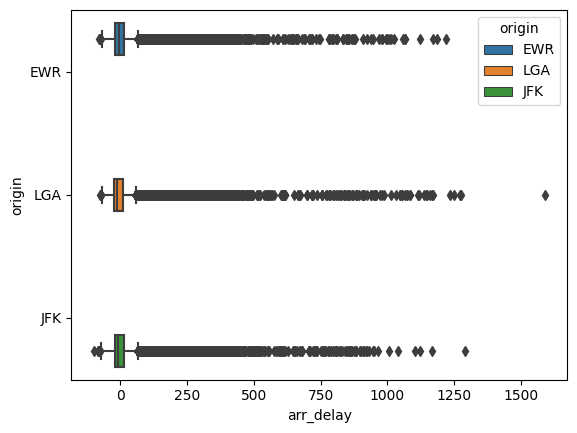

In [191]:
# 데이터를 이해하기 위해 다양한 탐색을 진행.
# 1) 출발지(origin)에 따라서 arr_delay 연관성이 있는지 탐색
sns.boxplot(data=df_final, x="arr_delay", y="origin", hue="origin")

<Axes: xlabel='arr_delay', ylabel='origin'>

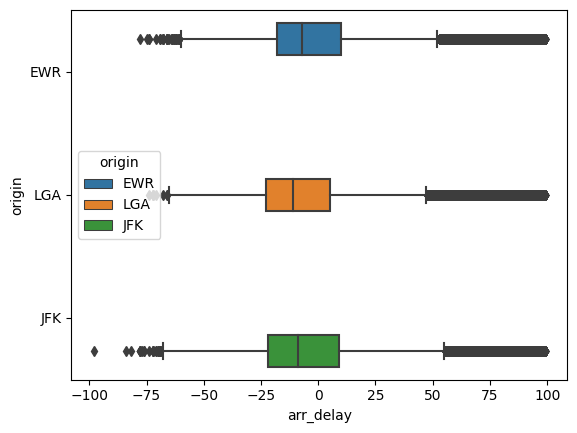

In [ ]:
# 잘 보이지 않으므로 filter를 줘서 한 번 더 데이터 관찰
sns.boxplot(data=df_final[df_final.arr_delay < 100], x="arr_delay", y="origin", hue="origin")

<Axes: xlabel='arr_delay', ylabel='engine'>

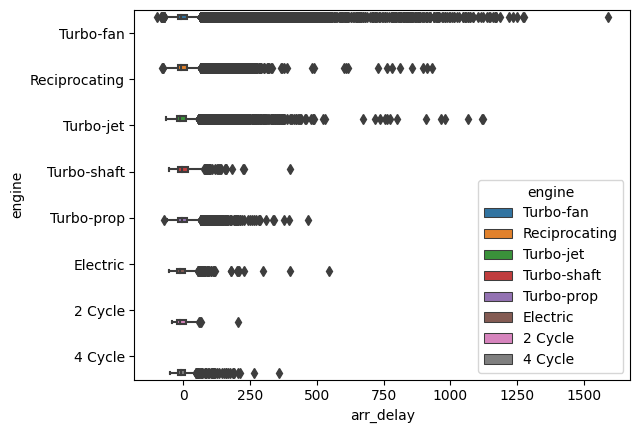

In [ ]:
# 2-1) 비행기 엔진(engine)에 따라서 arr delay 차이가 있지 않을까?
sns.boxplot(data=df_final, x="arr_delay", y="engine", hue="engine")

# Turbo-fan의 arr_delay가 길어지는 데이터 분포를 보임
# 2 Cycle에서는 arr_delay가 상대적으로 적음

<Axes: xlabel='distance', ylabel='engine'>

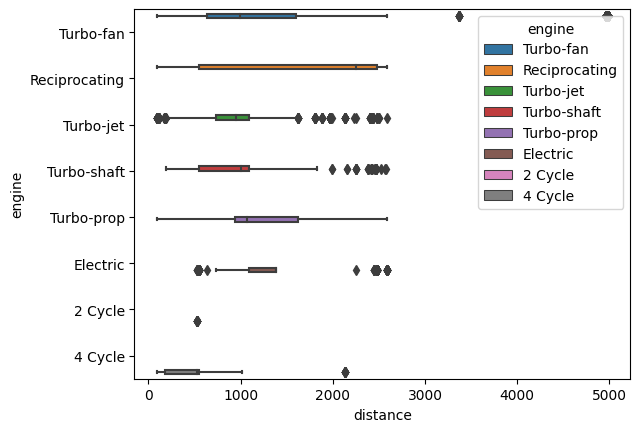

In [ ]:
# 2-2) 2-1)에서 본것처럼 엔진에 따라 arr_delay 차이가 보이는데, 특정 엔진이 distance 긴 곳에 많이 활용되서 그런것은 아닐까? (가정과 탐색)
sns.boxplot(data=df_final, x="distance", y="engine", hue="engine")

# Reciprocating이 상대적으로 긴 distance 운항을 많이 하는 것으로 보이나, Turbo-fan에 비하면 arr_delay가 적은 경향을 보임 (상대적임)

<Axes: xlabel='month', ylabel='arr_delay'>

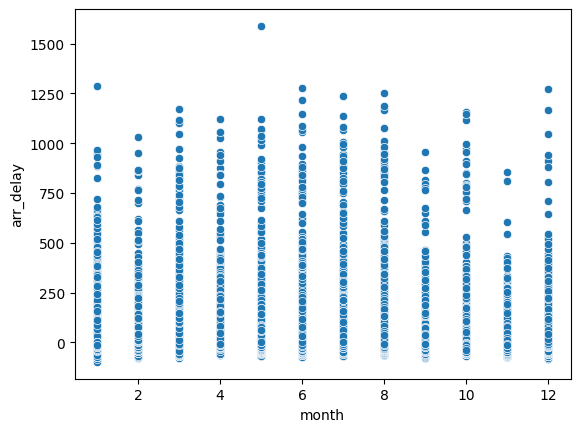

In [ ]:
# categorical column의 distinct value 수가 너무 많은 경우에는 scatter plot으로 전반적인 분포와 interaction 을 확인할 수 있다.
# 1) 운행된 month에 따른 탐색
sns.scatterplot(data=df_final, x="month", y="arr_delay")

<Axes: xlabel='carrier', ylabel='arr_delay'>

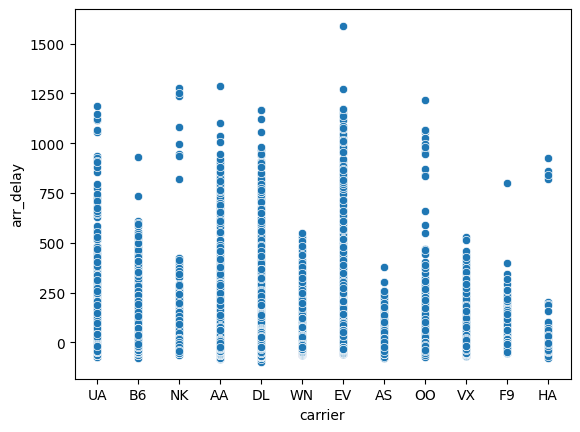

In [ ]:
# 2-1) 항공기의 항공사에 따른 탐색
sns.scatterplot(data=df_final, x="carrier", y="arr_delay")

<Axes: xlabel='arr_delay', ylabel='carrier'>

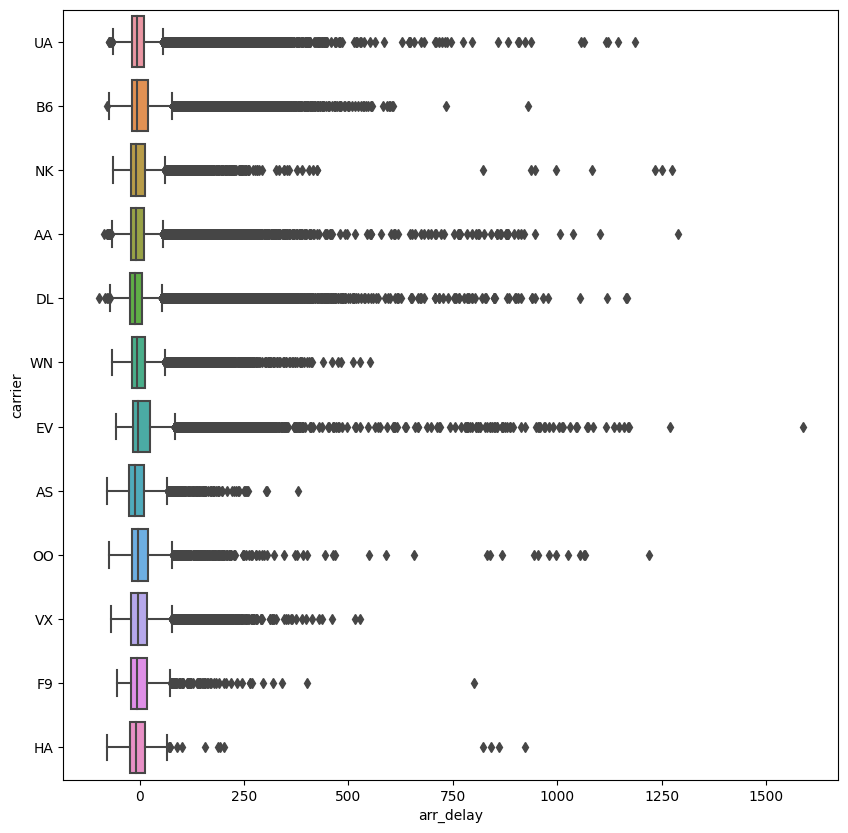

In [ ]:
# 2-2) 차이가 있어 보이니, boxplot으로 자세히 탐색.
plt.figure(figsize=(10,10))
sns.boxplot(data=df_final, x="arr_delay", y="carrier")

<Axes: xlabel='arr_delay', ylabel='carrier'>

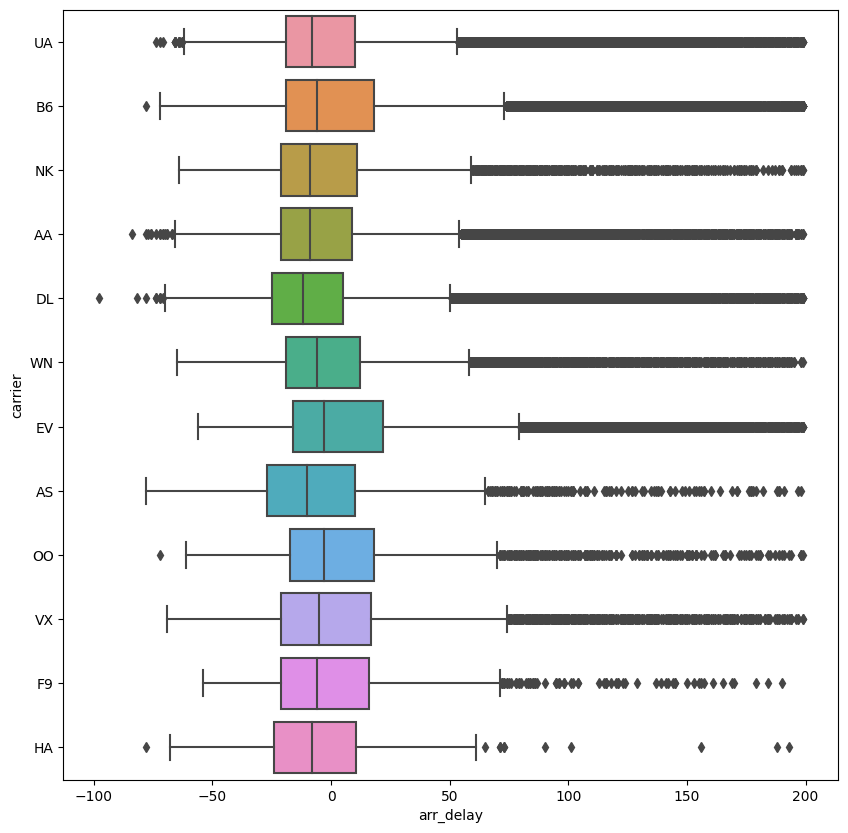

In [ ]:
# filter를 줘서 세부적으로 관착
plt.figure(figsize=(10,10))
sns.boxplot(data=df_final[df_final.arr_delay < 200], x="arr_delay", y="carrier")

# carrier에 따른 arr_delay 변화는 큰 유의미한 차이가 시각적으로 보이지는 않음

##### Categorical Data와 Numerical Data 검정
*   두 데이터의 연관성을 검정하는 방법에는 모수적 방법과 비모수적 방법으로 나뉨
*   모수적 방법 : ANOVA
*   비모수적 방법 : Kruskall-wallis
*   모수적 방법은 다양한 조건을 만족해야 하기 때문에 적용이 어려울 수 있으나, 정확도는 비모수적 방법에 비해 높음

##### 일원분산분석 (ANOVA)
*   카테고리별 numeric data 분포 차이를 검증
*   예를 들어, 성별에 따른 키 분포 분석 검증
*   전제 : 정규성, 등분산성, 독립성 (만족하지 않으면 해당 검정을 신뢰할 수 없음)
*   본 실습에서는 categorical data 에 따른
arr_delay 분포 관계를 검증.
*   pvalue는 0.05 이하인 경우, 귀무가설을 기각한다고 정한다. (pvalue 기준은 항상 다를 수 있음. 정확한 기준은 없으나 일반적으로 0.05 사용)
*   https://ko.wikipedia.org/wiki/분산_분석#일원분산분석(one-way_ANOVA)

정규성 검정
*   분산 분석을 위해서는 데이터가 정규성을 만족해야함
*   다양한 방법을 통해서 정규성을 검정 : qqplot, shapiro wilk test

((array([-4.57770925, -4.38855194, -4.2859886 , ...,  4.2859886 ,
          4.38855194,  4.57770925]),
  array([ -98.,  -84.,  -82., ..., 1276., 1289., 1589.])),
 (43.31356057220851, 7.104023113233141, 0.7829064086442739))

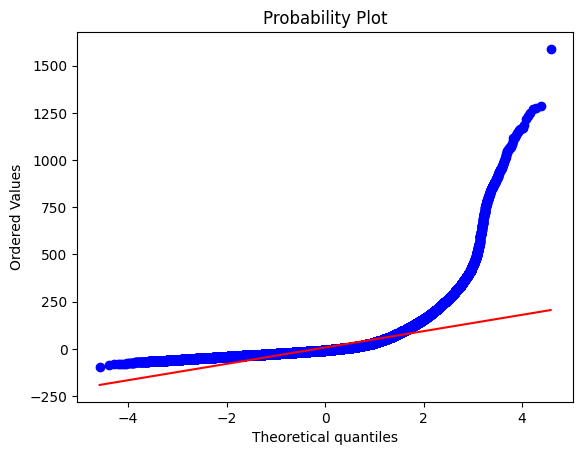

In [192]:
stats.probplot(df_final[target_column], dist=stats.norm, plot=plt)

정규성 만족하지 못함
*   정규성을 만족하지 못하므로, 등분산성 검정이 필요가 없음 (등분산성은 정규성을 전제)
*   일원분산분석을 통한 numeric data 검정 불가

##### 크루스칼 왈리스 검정 Kruskall-Wallis test (비모수 검정)
*   비모수 검정이기 때문에 정규성/등분산성을 만족하지 않아도됨
*   단, 비모수 검정이기 때문에 검정 결과 신뢰도가 모수 검정보다 떨어짐

In [193]:
df_final[list_categorical_columns].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294896 entries, 0 to 294895
Data columns (total 16 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   month          294896 non-null  int64 
 1   day            294896 non-null  int64 
 2   dep_time       294896 non-null  object
 3   carrier        294896 non-null  object
 4   flight         294896 non-null  int64 
 5   tailnum        294896 non-null  object
 6   origin         294896 non-null  object
 7   dest           294896 non-null  object
 8   faa            288914 non-null  object
 9   name           288914 non-null  object
 10  type           258583 non-null  object
 11  manufacturer   258583 non-null  object
 12  model          258583 non-null  object
 13  engine         258583 non-null  object
 14  dest_datetime  294896 non-null  object
 15  wind_dir       294896 non-null  object
dtypes: int64(3), object(13)
memory usage: 38.2+ MB


In [50]:
# kruskall 검정 (시간 많이 소요됨)
list_meaningful_column_by_kruskall = []

for column_name in list_categorical_columns:
  list_by_value = []
  for value in df_final[column_name].dropna().unique():
      df_tmp = df_final[df_final[column_name] == value][target_column].dropna()
      list_by_value.append(np.array(df_tmp))
  statistic, pvalue = kruskal(*list_by_value)
  if pvalue <= 0.05:
    list_meaningful_column_by_kruskall.append(column_name)
  print(column_name, ", ",statistic,", ", pvalue)
print("all categorical columns : ", len(list_categorical_columns))
print("selected columns by kruskal : ", len(list_meaningful_column_by_kruskall), list_meaningful_column_by_kruskall)

month ,  4517.169007971446 ,  0.0
day ,  2011.547273385221 ,  0.0
dep_time ,  37326.48957806564 ,  0.0
carrier ,  4749.565614373608 ,  0.0
flight ,  29017.821278409894 ,  0.0
tailnum ,  11539.928221649188 ,  0.0
origin ,  2058.537468530962 ,  0.0
dest ,  4846.796839777051 ,  0.0
faa ,  4662.731186640077 ,  0.0
name ,  4662.731186640077 ,  0.0
type ,  13.178586013957197 ,  0.004265896440157533
manufacturer ,  2791.479839545662 ,  0.0
model ,  6264.888258101361 ,  0.0
engine ,  252.9007963705475 ,  6.685238031099385e-51
dest_datetime ,  87157.90797333283 ,  0.0
wind_dir ,  1798.8922942734612 ,  0.0
all categorical columns :  16
selected columns by kruskal :  16 ['month', 'day', 'dep_time', 'carrier', 'flight', 'tailnum', 'origin', 'dest', 'faa', 'name', 'type', 'manufacturer', 'model', 'engine', 'dest_datetime', 'wind_dir']


##### insight
*   kruskal 검정에서 categorical data 모두 종속변수와 유의미한 관계를 갖는다고 검정됨



#### 2) numeric(continous) column 데이터 탐색

In [ ]:
sns.pairplot(data=df_final.loc[:,list_numeric_columns])

Output hidden; open in https://colab.research.google.com to view.

<Axes: >

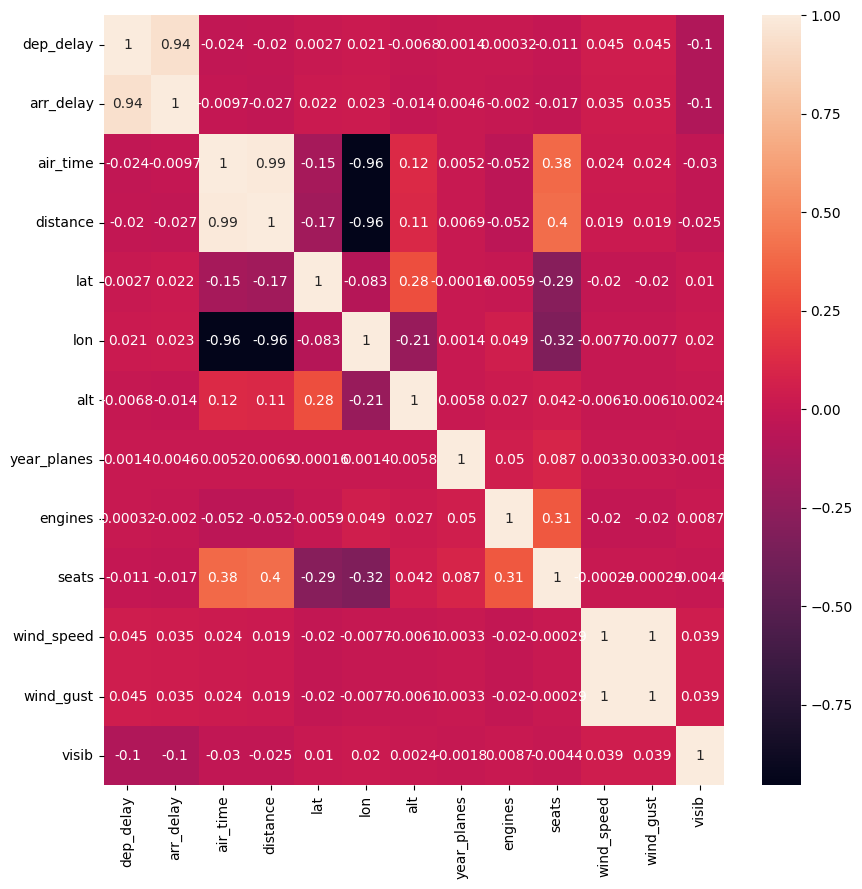

In [196]:
df_corr = df_final.loc[:,list_numeric_columns].corr()
plt.figure(figsize=(10,10))
sns.heatmap(df_corr, annot=True)

In [197]:
# 너무 높은 correlation을 갖는 데이터를 삭제. 단, 해당 correlation값을 신뢰할 수 있는지 확인필요
# 기준은 절대값 0.9 이상
index_corr_over_90 = np.where((abs(df_corr) > 0.90) & (df_corr != 1))
index_corr_over_90

(array([ 0,  1,  2,  2,  3,  3,  5,  5, 10, 11]),
 array([ 1,  0,  3,  5,  2,  5,  2,  3, 11, 10]))

In [198]:
len_corr_over_90 = len(index_corr_over_90[0])
left_columns = df_corr.columns[index_corr_over_90[0]]
right_columns = df_corr.columns[index_corr_over_90[1]]
for index in range(len_corr_over_90):
  print(left_columns[index], "<->", right_columns[index])

dep_delay <-> arr_delay
arr_delay <-> dep_delay
air_time <-> distance
air_time <-> lon
distance <-> air_time
distance <-> lon
lon <-> air_time
lon <-> distance
wind_speed <-> wind_gust
wind_gust <-> wind_speed


In [51]:
# 중복되는 것들이 많기 때문에 아래와 같이 3개 컬럼을 제거하기로 결정
list_removed_by_correlation = ["air_time", "lon", "wind_speed"]

## 3. Data Processing 2

### 3-1 Feature Selection
    1) high corrleation : air_time, lon, wind_speed
    2) duplicated columns : faa, origin, dest (join할 때 사용된 key값으로, 다른 데이터의 key와 동일하기 때문에 제거)

In [52]:
list_removed_by_correlation

['air_time', 'lon', 'wind_speed']

In [53]:
column_removed = list_removed_by_correlation + [ "faa", "origin", "dest" ]
df_final = df_final.drop(column_removed, axis=1).copy()

### 3-2 Missing Values

In [54]:
print(len(df_final))
df_final.isna().sum()

294896


month                0
day                  0
dep_time             0
dep_delay            0
arr_delay            0
carrier              0
flight               0
tailnum              0
distance             0
name              5982
lat               5982
alt               5982
year_planes      43853
type             36313
manufacturer     36313
model            36313
engines          36313
seats            36930
engine           36313
dest_datetime        0
wind_dir             0
wind_gust          783
visib              783
dtype: int64

In [55]:
# 결측치 데이터를 제거. 다른 방법으로 채우는 것도 실험해볼 수 있으니 시도해보는 것을 추천
df_filtered = df_final.dropna().reset_index()
df_filtered = df_filtered.drop(["index"], axis=1)
# df_filtered = df_final.dropna().resset_index(drop=True)
df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 245219 entries, 0 to 245218
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   month          245219 non-null  int64  
 1   day            245219 non-null  int64  
 2   dep_time       245219 non-null  object 
 3   dep_delay      245219 non-null  float64
 4   arr_delay      245219 non-null  float64
 5   carrier        245219 non-null  object 
 6   flight         245219 non-null  int64  
 7   tailnum        245219 non-null  object 
 8   distance       245219 non-null  float64
 9   name           245219 non-null  object 
 10  lat            245219 non-null  float64
 11  alt            245219 non-null  float64
 12  year_planes    245219 non-null  float64
 13  type           245219 non-null  object 
 14  manufacturer   245219 non-null  object 
 15  model          245219 non-null  object 
 16  engines        245219 non-null  float64
 17  seats          245219 non-nul

In [56]:
df_filtered.isna().sum()

month            0
day              0
dep_time         0
dep_delay        0
arr_delay        0
carrier          0
flight           0
tailnum          0
distance         0
name             0
lat              0
alt              0
year_planes      0
type             0
manufacturer     0
model            0
engines          0
seats            0
engine           0
dest_datetime    0
wind_dir         0
wind_gust        0
visib            0
dtype: int64

### 3-3 New Columns

In [205]:
pd.to_datetime(df_filtered["dest_datetime"])

0        2017-10-02 00:00:00
1        2017-10-01 05:00:00
2        2017-10-01 05:00:00
3        2017-10-01 05:00:00
4        2017-10-01 05:00:00
                 ...        
245214   2017-09-30 22:00:00
245215   2017-09-30 22:00:00
245216   2017-09-30 22:00:00
245217   2017-09-30 23:00:00
245218   2017-09-30 23:00:00
Name: dest_datetime, Length: 245219, dtype: datetime64[ns]

In [57]:
# 실제 출발 시간의 hour, minute, weekday 데이터 생성
# time관련된 object data는 제거
df_filtered["hour_dep"] = df_filtered.apply(lambda x : int(int(x.dep_time)/100), axis=1)
df_filtered["minute_dep"] = df_filtered.apply(lambda x : int(int(x.dep_time)%100), axis=1)
df_filtered["weekday_dep"] = pd.to_datetime(df_filtered["dest_datetime"]).dt.weekday
df_filtered = df_filtered.drop(["dep_time", "dest_datetime"], axis=1)

In [58]:
df_filtered.head(2)

,month,day,dep_delay,arr_delay,carrier,flight,tailnum,distance,name,lat,...,model,engines,seats,engine,wind_dir,wind_gust,visib,hour_dep,minute_dep,weekday_dep
0,10,1,193.0,182.0,UA,1537,N54711,1085.0,Miami International Airport,25.7932,...,737-724,2.0,149.0,Turbo-fan,40.0,10.594357,10.0,0,27,0
1,10,1,-6.0,-18.0,UA,1161,N37287,1400.0,George Bush Intercontinental Houston Airport,29.9844,...,737-824,2.0,149.0,Turbo-fan,360.0,18.540125,10.0,5,19,6


In [59]:
list_categorical_columns = list(df_filtered.select_dtypes(include=['int64', 'object']).columns)
list_numeric_columns = list(df_filtered.select_dtypes(include=['float64']).columns)
print(len(df_filtered.columns))
print("categorical : ",len(list_categorical_columns))
print("numerical : ", len(list_numeric_columns))

24
categorical :  14
numerical :  10


### 3-4 Feature Transformation

In [61]:
df_filtered.head(5)

,month,day,dep_delay,arr_delay,carrier,flight,tailnum,distance,name,lat,...,model,engines,seats,engine,wind_dir,wind_gust,visib,hour_dep,minute_dep,weekday_dep
0,10,1,193.0,182.0,UA,1537,N54711,1085.0,Miami International Airport,25.793200,...,737-724,2.0,149.0,Turbo-fan,40.0,10.594357,10.0,0,27,0
1,10,1,-6.0,-18.0,UA,1161,N37287,1400.0,George Bush Intercontinental Houston Airport,29.984400,...,737-824,2.0,149.0,Turbo-fan,360.0,18.540125,10.0,5,19,6
2,10,1,-1.0,-4.0,B6,27,N547JB,937.0,Orlando International Airport,28.429399,...,A320-232,2.0,200.0,Turbo-fan,360.0,18.540125,10.0,5,44,6
3,10,1,-4.0,-17.0,UA,761,N38446,733.0,Chicago O'Hare International Airport,41.978600,...,737-924ER,2.0,191.0,Turbo-fan,360.0,22.513008,10.0,5,46,6
4,10,1,-8.0,-4.0,NK,521,N675NK,1065.0,Fort Lauderdale Hollywood International Airport,26.072599,...,A321-231,2.0,379.0,Turbo-fan,360.0,18.540125,10.0,5,52,6


In [60]:
for column_name in df_filtered.columns:
  print(column_name, df_filtered[column_name].nunique())

month 12
day 31
dep_delay 709
arr_delay 762
carrier 12
flight 3278
tailnum 3417
distance 195
name 104
lat 104
alt 97
year_planes 59
type 4
manufacturer 65
model 208
engines 4
seats 60
engine 7
wind_dir 37
wind_gust 28
visib 21
hour_dep 25
minute_dep 60
weekday_dep 7


In [62]:
# wind_dir을 카테고리화 (binning)
def category_wind_dir(value):
  value = float(value)
  rlt = 0
  if value < 60:
    rlt = 0
  elif (value >= 60) & (value < 120):
    rlt= 1
  elif (value >= 120) & (value < 180):
    rlt= 2
  elif (value >= 180) & (value < 240):
    rlt= 3
  elif (value >= 240) & (value < 300):
    rlt= 4
  else:
    rlt= 5
  return str(rlt)
df_filtered["wind_dir_category"] = df_filtered["wind_dir"].apply(lambda x : category_wind_dir(x))

In [63]:
df_filtered = df_filtered.drop("wind_dir", axis=1)

In [64]:
list_categorical_columns = list(df_filtered.select_dtypes(include=['int64', 'object']).columns)
list_numeric_columns = list(df_filtered.select_dtypes(include=['float64']).columns)
print(len(df_filtered.columns))
print("categorical : ",len(list_categorical_columns))
print("numerical : ", len(list_numeric_columns))

24
categorical :  14
numerical :  10


##### Encoding 진행
*   Tree 계열 ML을 사용하기로 결정한다면, categorical data를 one-hot encoding하지 않고 이산형 encoding을 진행하는 것도 가능한 방법이 될 수 있음
*   너무 많은 category가 있을 경우에는 data columns수가 너무 많아져 오히려 학습에 방해되기 떄문



In [65]:
for column_name in list_categorical_columns:
    ce = LabelEncoder()
    ce.fit(df_filtered[column_name])
    df_filtered[column_name] = ce.transform(df_filtered[column_name])

In [66]:
df_filtered

,month,day,dep_delay,arr_delay,carrier,flight,tailnum,distance,name,lat,...,model,engines,seats,engine,wind_gust,visib,hour_dep,minute_dep,weekday_dep,wind_dir_category
0,9,0,193.0,182.0,9,1033,1449,1085.0,62,25.793200,...,39,2.0,149.0,3,10.594357,10.0,0,27,0,0
1,9,0,-6.0,-18.0,9,801,912,1400.0,38,29.984400,...,60,2.0,149.0,3,18.540125,10.0,5,19,6,5
2,9,0,-1.0,-4.0,2,17,1450,937.0,71,28.429399,...,109,2.0,200.0,3,18.540125,10.0,5,44,6,5
3,9,0,-4.0,-17.0,9,507,1021,733.0,20,41.978600,...,68,2.0,191.0,3,22.513008,10.0,5,46,6,5
4,9,0,-8.0,-4.0,7,353,1922,1065.0,33,26.072599,...,113,2.0,379.0,3,18.540125,10.0,5,52,6,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245214,8,29,-7.0,-25.0,2,1239,727,209.0,95,43.111198,...,151,2.0,20.0,3,17.215830,10.0,22,38,5,5
245215,8,29,-4.0,-19.0,2,1385,817,301.0,13,42.940498,...,151,2.0,20.0,3,17.215830,10.0,22,41,5,5
245216,8,29,3.0,-9.0,5,344,521,1620.0,28,39.861698,...,108,2.0,182.0,3,15.891535,10.0,22,48,5,5
245217,8,29,2.0,-10.0,2,477,662,187.0,36,42.364300,...,151,2.0,20.0,3,18.540125,10.0,23,19,5,5


##### Normalization (MinMaxScaler)

In [67]:
df_feature = df_filtered.drop("arr_delay", axis=1).copy()
df_label = df_filtered["arr_delay"].copy()

In [68]:
scaler = MinMaxScaler()
df_feature = pd.DataFrame(scaler.fit_transform(df_feature), columns=df_feature.columns)

In [69]:
df_feature.head(2)

,month,day,dep_delay,carrier,flight,tailnum,distance,name,lat,alt,...,model,engines,seats,engine,wind_gust,visib,hour_dep,minute_dep,weekday_dep,wind_dir_category
0,0.818182,0.0,0.140774,0.818182,0.315227,0.424180,0.202863,0.601942,0.112267,0.000606,...,0.188406,0.333333,0.268603,0.5,0.285714,1.0,0.000000,0.457627,0.0,0.0
1,0.818182,0.0,0.014585,0.818182,0.244431,0.266979,0.267280,0.368932,0.217427,0.014087,...,0.289855,0.333333,0.268603,0.5,0.500000,1.0,0.208333,0.322034,1.0,1.0


## 4. Model Analysis

### 4-1. Base Model Learning

In [218]:
X_train, X_test, y_train, y_test = train_test_split(df_feature, df_label, test_size = 0.3, random_state=random_state)

In [117]:
regr = RandomForestRegressor(max_depth=4, random_state=random_state)
regr.fit(X_train, y_train)

RandomForestRegressor(max_depth=4, random_state=1234)

In [118]:
y_prd=regr.predict(X_test)
print("rmse : %f"%(mean_squared_error(y_test, y_prd)**0.5))

rmse : 18.740307


### 4-2. Optimization 1

In [119]:
hyper_params = {'n_estimators' : [10, 15, 20, 25],
                'max_depth' : [4, 8, 10],
                'min_samples_leaf' : [4, 8, 10],
                'max_features' : [0.5, 0.7, 0.9]
               }

rf_regr = RandomForestRegressor(random_state = random_state, n_jobs = -1)
grid_cv = GridSearchCV(rf_regr, param_grid = hyper_params, cv = 3, n_jobs = -1)
grid_cv.fit(X_train, y_train)

print('best model hyper-parameter : ', grid_cv.best_params_)

best model hyper-parameter :  {'max_depth': 10, 'max_features': 0.9, 'min_samples_leaf': 4, 'n_estimators': 25}


In [120]:
y_prd=grid_cv.predict(X_test)
print("rmse : %f"%(mean_squared_error(y_test, y_prd)**0.5))

rmse : 17.933205


### 4-3. Optimization 2

Bagging
- 한 개의 데이터 -> 여러 sample 추출 -> 독립적으로 모델들을 학습
- 최종적으로 독립된 모델들을 가지고 final model -> 모델들을 avg, 한 개만
- generalization (일반화), 병렬처리 장점

Boosting
- 한 개의 데이터 -> 한 개 sample 추출 -> 모델 1개를 학습
- 반복 : 앞에서 만든 모델의 weakness 점을 보완하는 모델을 추가 학습해줘여
- 반복
- 최종 모델이 구해질거야.
- 성능이 좋아요. overfitting 취약, sequential (병렬x)

##### XGBoost
##### https://xgboost.readthedocs.io/en/stable/python/python_api.html
    1) Extreme Gradient Boosting의 약자이다.
    2) Gradient Boost Algorithm을 병렬 학습할 수 있도록 지원하는 라이브러리
    3) Regression, Classification 을 모두 처리 가능하다
    4) Regularization 기능을 지원한다
    5) early stopping 기능을 지원한다

In [121]:
hyper_params_xgb = {"colsample_bytree":[1.0],
                    "min_child_weight":[1.0,1.2],
                    'max_depth': [4, 8, 10],
                    'n_estimators': [10, 15, 20]}

xgb_regr = XGBRegressor(n_estimators = 500, max_depth = 9,min_child_weight= 1.2,colsample_bytree = 1.0)
grid_cv_xgb = GridSearchCV(xgb_regr, param_grid = hyper_params_xgb, cv = 3, n_jobs = -1)
grid_cv_xgb.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=3,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None, colsample_bytree=1.0,
                                    device=None, early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, ma...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=9, max_leaves=None,
                                    min_child_weight=1.2, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=500,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [1.0], 'max_depth': [4, 8, 10],
                         'min_child_weight': [1.0, 1.2],
                         'n_estimators': [10, 15, 20]})

In [122]:
y_prd=grid_cv_xgb.predict(X_test)
print("rmse : %f"%(mean_squared_error(y_test, y_prd)**0.5))

rmse : 19.583051


### 4-4. Model Analysis

In [123]:
rf_final_model = RandomForestRegressor(**grid_cv.best_params_)
rf_final_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, max_features=0.9, min_samples_leaf=4,
                      n_estimators=25)

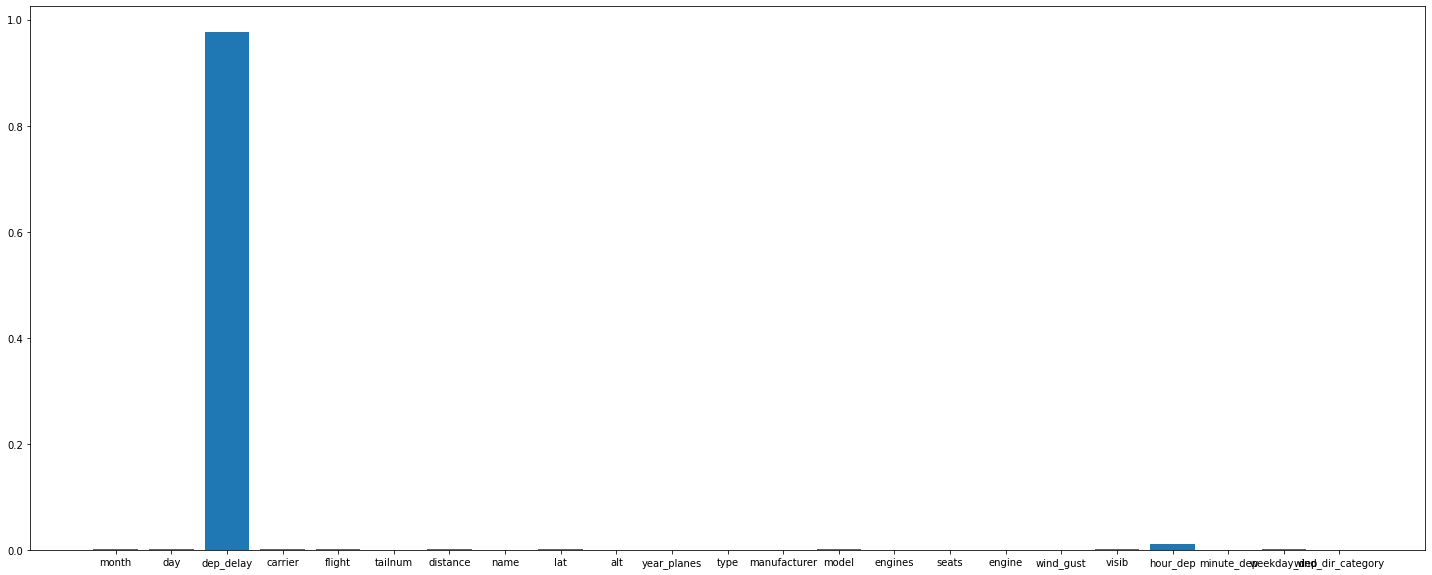

In [ ]:
plt.figure(figsize=(25,10))
ax = plt.bar(list(df_feature.columns),rf_final_model.feature_importances_)

### 4-5. 추가 분석
#### 추가 분석 - dep_delay외에 다른 특성들은 비행 지연시간에 얼마나 영향을 미칠지 insight를 얻고싶다

In [124]:
df_feature_added = df_filtered.drop(["arr_delay", "dep_delay"], axis=1).copy()

In [125]:
X_train_added, X_test_added, y_train_added, y_test_added = train_test_split(df_feature_added, df_label, test_size = 0.3, random_state=random_state)

In [ ]:
hyper_params_xgb = {"colsample_bytree":[1.0],
                    "min_child_weight":[1.0,1.2],
                    'max_depth': [4, 8, 10],
                    'n_estimators': [10, 15, 20, 25]}

xgb_regr = XGBRegressor(n_estimators = 500, max_depth = 9,min_child_weight= 1.2,colsample_bytree = 1.0)
grid_cv_xgb = GridSearchCV(xgb_regr, param_grid = hyper_params_xgb, cv = 3, n_jobs = -1)
grid_cv_xgb.fit(X_train_added, y_train_added)

[11:49:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=3,
             estimator=XGBRegressor(colsample_bytree=1.0, max_depth=9,
                                    min_child_weight=1.2, n_estimators=500),
             n_jobs=-1,
             param_grid={'colsample_bytree': [1.0], 'max_depth': [4, 8, 10],
                         'min_child_weight': [1.0, 1.2],
                         'n_estimators': [10, 15, 20, 25]})

In [ ]:
xgb_added_model = XGBRegressor(**grid_cv.best_params_)
xgb_added_model.fit(X_train_added, y_train_added)

[11:49:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(max_depth=10, max_features=0.9, min_samples_leaf=4,
             n_estimators=25)

In [ ]:
y_prd=grid_cv_xgb.predict(X_test_added)
print("rmse : %f"%(mean_squared_error(y_test, y_prd)**0.5))

rmse : 46.282019


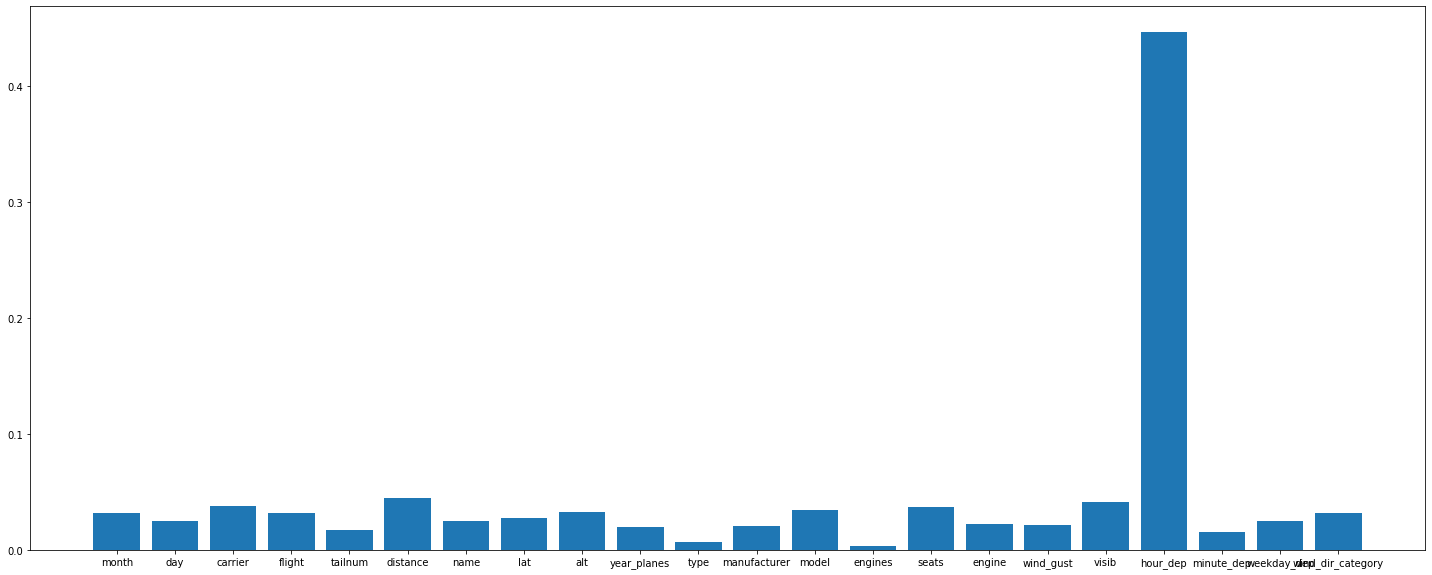

In [ ]:
plt.figure(figsize=(25,10))
ax = plt.bar(list(df_feature_added.columns),xgb_added_model.feature_importances_)